<a href="https://colab.research.google.com/github/ArnyWu/-Preview-AI-/blob/main/FER2013_with_VGG%26Resnet50_by_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fer2013:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F786787%2F1351797%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240818%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240818T100844Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da08c026cd1846bdb1d3c39f4c1237797a32e42eef0eb5ec2e3018735a14a26eb68a016f7d067b18b0eb4a7741cd92ce9e2faaee16a6cc76492d45f5367422ca82db54f689756dcd77dd3c89e50262a5cd9483f388294cb3e801058ebec32c07df3e4d15b108b9aed15e507aa506263908b97f7bc5f8cb05fb7dd3ede7b93f50ab34338ddbb6c7b3cf92661072f3896bc0154e34f199f5e66270a82ee858322aa6ff9000acaa30d8acbab6d4ccf4c0a475ab36821dbee3c8cfb502fb46141415660f79e84645c351970ccea96d4f5cd57f37fb308ef03b5fef60fec2e9fa2890039c81b592b4e586748c2d70c480fcc75f6331d0c7d5ad24a445de9078ffd37b2'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
train_data_path = '/kaggle/input/fer2013/train'
test_data_path = '/kaggle/input/fer2013/test'

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG19, ResNet50
from tensorflow.keras.losses import CategoricalCrossentropy

2024-08-18 07:47:24.569613: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 07:47:24.569731: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 07:47:24.831006: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 創建 ImageDataGenerator 物件
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 設定 20% 為驗證集
)

# 載入訓練資料並分割出驗證集
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(48, 48),
    color_mode='rgb',  # 設置為RGB，因為我們會處理RGB圖像
    batch_size=64,
    class_mode='categorical',
    subset='training'  # 訓練集
)

validation_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(48, 48),
    color_mode='rgb',  # 設置為RGB
    batch_size=64,
    class_mode='categorical',
    subset='validation'  # 驗證集
)

# 創建 ImageDataGenerator 物件僅用於測試資料
test_datagen = ImageDataGenerator(
    rescale=1./255
)

# 載入測試資料
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(48, 48),
    color_mode='rgb',  # 設置為RGB
    batch_size=64,
    class_mode='categorical'
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


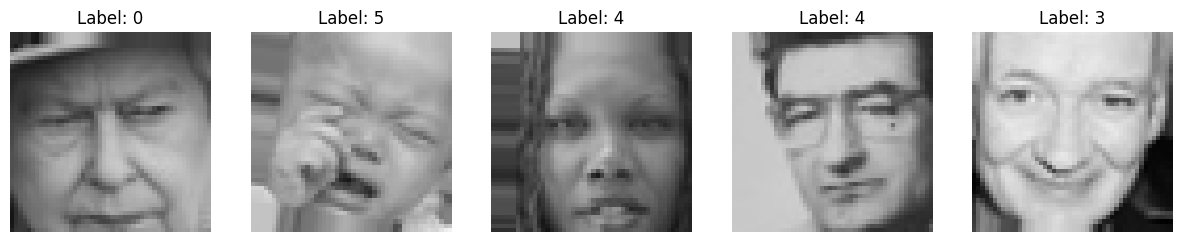

In [ ]:
# 從訓練生成器中獲取一批影像和對應的標籤
images, labels = next(train_generator)

# 設定要顯示的影像數量
num_images_to_display = 5

# 創建一個圖形來顯示影像
plt.figure(figsize=(15, 5))

for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(images[i])  # 直接顯示RGB圖像
    plt.title(f'Label: {labels[i].argmax()}')  # 顯示對應的標籤
    plt.axis('off')

plt.show()

In [ ]:
from tensorflow.keras.models import Model

# 輸入層
input_tensor = Input(shape=(48, 48, 3))

# 預訓練的 VGG19 模型
base_model = VGG19(weights='imagenet', include_top=False, input_tensor=input_tensor)

# 自定義層
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_tensor = Dense(7, activation='softmax')(x)

# 定義模型
vgg_model = Model(inputs=input_tensor, outputs=output_tensor)
vgg_model.name = 'VGG19'
vgg_model.layers[0].trainable = False

# 編譯模型
vgg_model.compile(optimizer=Adam(learning_rate = 0.0001,
                          beta_1 = 0.9, beta_2 = 0.999), loss='categorical_crossentropy', metrics=['accuracy'])
vgg_model.summary()


Model: "VGG19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)     │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128)            │             

 Total params: 20,090,951 (76.64 MB)

 Trainable params: 20,090,951 (76.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 建立ResNet50模型
# 輸入層
input_tensor = Input(shape=(48, 48, 3))

# 預訓練的 ResNet50 模型
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

# 自定義層
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_tensor = Dense(7, activation='softmax')(x)

# 定義模型
resnet_model = Model(inputs=input_tensor, outputs=output_tensor)
resnet_model.name = 'ResNet50'
base_model.trainable = True

# 編譯模型
resnet_model.compile(optimizer=Adam(learning_rate = 0.0001,
                          beta_1 = 0.9, beta_2 = 0.999), loss='categorical_crossentropy', metrics=['accuracy'])
resnet_model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32      │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 54, 54, 3) │          0 │ input_layer_32[0… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 24, 24,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 24, 24,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 24, 24,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 26, 26,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 12, 12,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 12, 12,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 12, 12,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 12, 12,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 12, 12,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 12, 12,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 12, 12,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 12, 12,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 12, 12,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 12, 12,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 12, 12,    │      1,024 │ conv2_block1_3_c

 Total params: 24,637,319 (93.98 MB)

 Trainable params: 24,584,199 (93.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# 定義回調函數
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

In [ ]:
def plot_comparison(vgg_history, resnet_history):
    # 繪製訓練和驗證損失
    plt.figure(figsize=(14, 6))

    # 損失圖
    plt.subplot(1, 2, 1)
    plt.plot(vgg_history.history['loss'], label='VGG19 Train Loss')
    plt.plot(vgg_history.history['val_loss'], label='VGG19 Val Loss')
    plt.plot(resnet_history.history['loss'], label='ResNet50 Train Loss')
    plt.plot(resnet_history.history['val_loss'], label='ResNet50 Val Loss')
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 精確度圖
    plt.subplot(1, 2, 2)
    plt.plot(vgg_history.history['accuracy'], label='VGG19 Train Accuracy')
    plt.plot(vgg_history.history['val_accuracy'], label='VGG19 Val Accuracy')
    plt.plot(resnet_history.history['accuracy'], label='ResNet50 Train Accuracy')
    plt.plot(resnet_history.history['val_accuracy'], label='ResNet50 Val Accuracy')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 1/50
 56/359 ━━━━━━━━━━━━━━━━━━━━ 1:07 222ms/step - accuracy: 0.1903 - loss: 1.9608

W0000 00:00:1723970634.128286     163 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


359/359 ━━━━━━━━━━━━━━━━━━━━ 84s 210ms/step - accuracy: 0.2584 - loss: 1.8198 - val_accuracy: 0.4727 - val_loss: 1.4045 - learning_rate: 1.0000e-04
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 72s 198ms/step - accuracy: 0.4633 - loss: 1.4116 - val_accuracy: 0.5217 - val_loss: 1.2827 - learning_rate: 1.0000e-04
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 74s 203ms/step - accuracy: 0.5155 - loss: 1.2971 - val_accuracy: 0.5529 - val_loss: 1.1896 - learning_rate: 1.0000e-04
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 72s 198ms/step - accuracy: 0.5401 - loss: 1.2317 - val_accuracy: 0.5659 - val_loss: 1.1400 - learning_rate: 1.0000e-04
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 71s 194ms/step - accuracy: 0.5750 - loss: 1.1557 - val_accuracy: 0.5839 - val_loss: 1.1199 - learning_rate: 1.0000e-04
Epoch 6/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 71s 194ms/step - accuracy: 0.5989 - loss: 1.1038 - val_accuracy: 0.5861 - val_loss: 1.0935 - learning_rate: 1.0000e-04
Epoch 7/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 71s 195ms/step - 

W0000 00:00:1723972306.312409     163 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


333/359 ━━━━━━━━━━━━━━━━━━━━ 6s 253ms/step - accuracy: 0.3236 - loss: 1.9046

W0000 00:00:1723972390.331705     164 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.3281 - loss: 1.8855

W0000 00:00:1723972398.298130     162 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


359/359 ━━━━━━━━━━━━━━━━━━━━ 175s 306ms/step - accuracy: 0.3282 - loss: 1.8849 - val_accuracy: 0.2106 - val_loss: 2.0133 - learning_rate: 0.0010
Epoch 2/50


W0000 00:00:1723972415.831866     164 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


359/359 ━━━━━━━━━━━━━━━━━━━━ 71s 195ms/step - accuracy: 0.4524 - loss: 1.4506 - val_accuracy: 0.3405 - val_loss: 1.7638 - learning_rate: 0.0010
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 71s 193ms/step - accuracy: 0.4626 - loss: 1.4237 - val_accuracy: 0.3951 - val_loss: 1.5651 - learning_rate: 0.0010
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 70s 192ms/step - accuracy: 0.4516 - loss: 1.4375 - val_accuracy: 0.4362 - val_loss: 1.4579 - learning_rate: 0.0010
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 71s 194ms/step - accuracy: 0.4847 - loss: 1.3636 - val_accuracy: 0.4684 - val_loss: 1.3925 - learning_rate: 0.0010


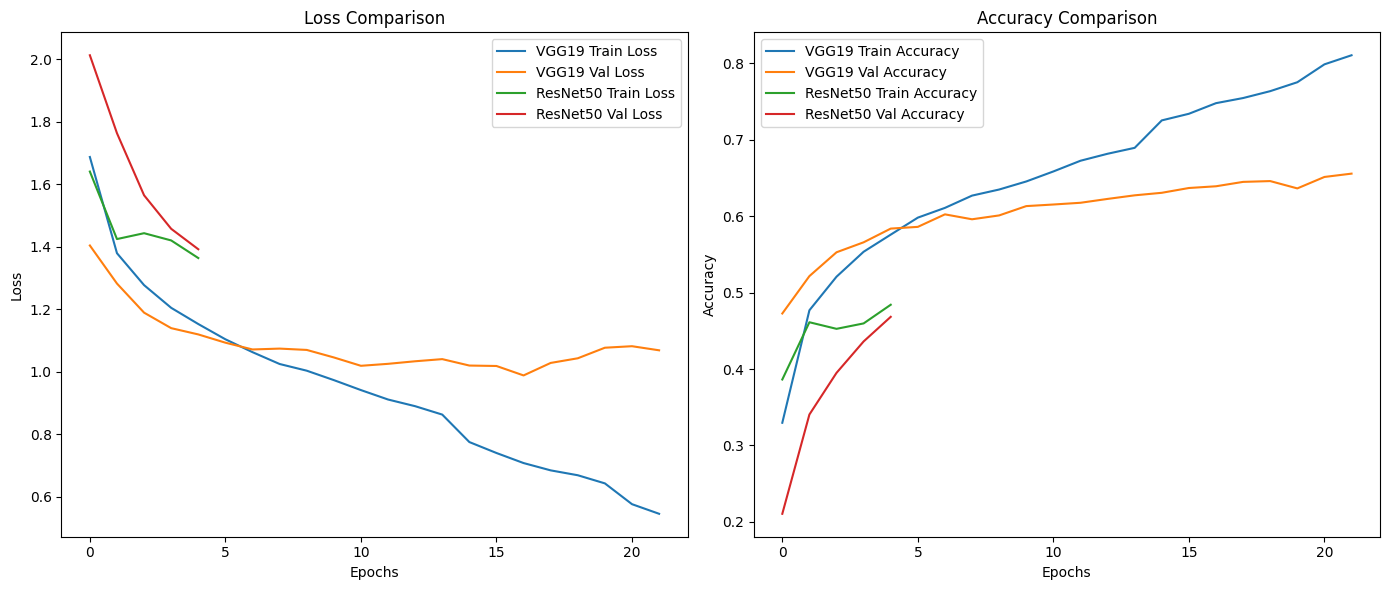

In [ ]:
vgg_history = vgg_model.fit(train_generator,
                            epochs=50,
                            validation_data=validation_generator,
                            callbacks=[early_stopping, reduce_lr])

Epoch 1/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 74s 202ms/step - accuracy: 0.3758 - loss: 1.6303 - val_accuracy: 0.2999 - val_loss: 1.8461 - learning_rate: 1.0000e-04
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 70s 193ms/step - accuracy: 0.4564 - loss: 1.4572 - val_accuracy: 0.4221 - val_loss: 1.5446 - learning_rate: 1.0000e-04
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 72s 197ms/step - accuracy: 0.5017 - loss: 1.3295 - val_accuracy: 0.4912 - val_loss: 1.4085 - learning_rate: 1.0000e-04
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 73s 199ms/step - accuracy: 0.5402 - loss: 1.2513 - val_accuracy: 0.5186 - val_loss: 1.3309 - learning_rate: 1.0000e-04
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 71s 195ms/step - accuracy: 0.5506 - loss: 1.2035 - val_accuracy: 0.5341 - val_loss: 1.2319 - learning_rate: 1.0000e-04
Epoch 6/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 71s 195ms/step - accuracy: 0.5769 - loss: 1.1465 - val_accuracy: 0.5522 - val_loss: 1.2349 - learning_rate: 1.0000e-04
Epoch 7/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 71s 19

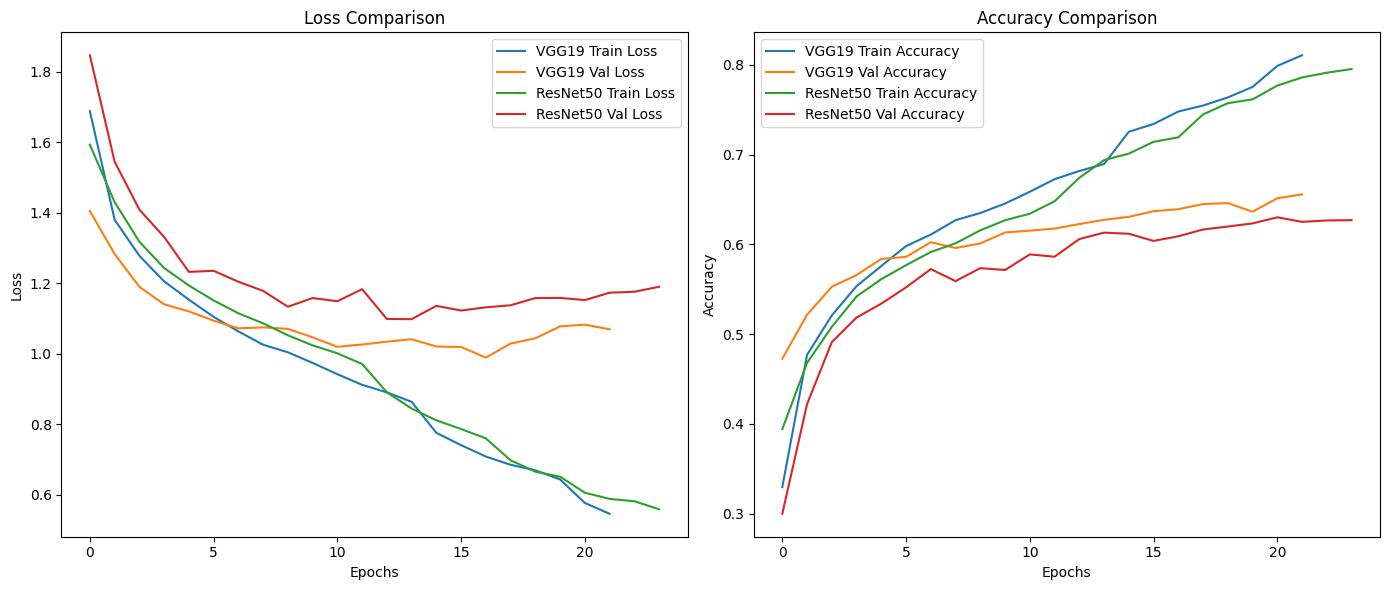

In [ ]:
resnet_history = resnet_model.fit(train_generator,
                                  epochs=50,
                                  validation_data=validation_generator,
                                  callbacks=[early_stopping, reduce_lr])

# 繪製比較圖表
plot_comparison(vgg_history, resnet_history)